In [1]:
import yaml
 
try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("Yaml configuration file not found!")

In [3]:
import pandas as pd

df = pd.read_csv("../data/clean/alzheimers_top5.csv")
df

,FunctionalAssessment,ADL,MemoryComplaints,MMSE,BehavioralProblems,Diagnosis
0,6.518877,1.725883,0,21.463532,0,0
1,7.118696,2.592424,0,20.613267,0,0
2,5.895077,7.119548,0,7.356249,0,0
3,8.965106,6.481226,0,13.991127,1,0
4,6.045039,0.014691,0,13.517609,0,0
...,...,...,...,...,...,...
2144,0.238667,4.492838,0,1.201190,0,1
2145,8.687480,9.204952,0,6.458060,1,1
2146,1.972137,5.036334,0,17.011003,0,1
2147,5.173891,3.785399,0,4.030491,0,1


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

Cross-Validation Scores: [0.84883721 0.84302326 0.85755814 0.83139535 0.82798834]
Mean CV Accuracy: 0.8417604583361584

Test Accuracy: 0.8604651162790697

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89       267
           1       0.88      0.74      0.80       163

    accuracy                           0.86       430
   macro avg       0.86      0.84      0.85       430
weighted avg       0.86      0.86      0.86       430



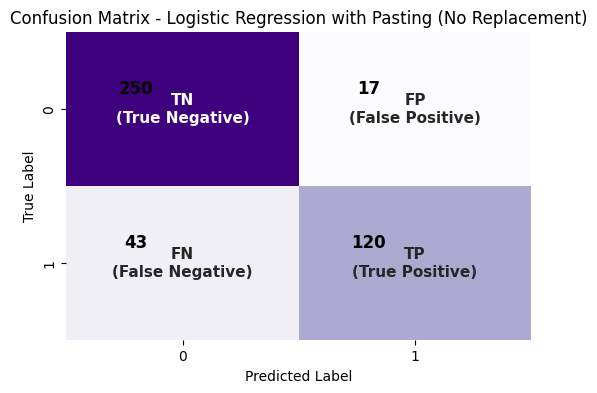

In [5]:
# ================================================
# LOGISTIC REGRESSION + PASTING ENSEMBLE (no replacement)
# ================================================
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# ================================================
# STEP 0 — Data Preparation
# ================================================
# 1. Separate features and target
X = df.drop(columns=["Diagnosis"])
y = df["Diagnosis"]
# 2. Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)
# 3. Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# ================================================
# STEP 1 — Base Model: Logistic Regression
# ================================================
base_model = LogisticRegression(
    solver="lbfgs",       # stable and supports L2
    penalty="l2",
    C=1.0,
    max_iter=1000,
    random_state=0
)
# ================================================
# STEP 2 — Ensemble Model: Pasting (Bagging without replacement)
# ================================================
pasting_model = BaggingClassifier(
    estimator=base_model,  # use Logistic Regression as base
    n_estimators=50,       # number of models in the ensemble
    max_samples=0.8,       # each model sees 80% of the training data
    bootstrap=False,       # :no_entry_sign: no replacement = PASTING
    n_jobs=-1,             # use all CPU cores
    random_state=0
)
# Train the ensemble
pasting_model.fit(X_train_scaled, y_train)
# ================================================
# STEP 3 — Cross-Validation (5 folds)
# ================================================
cv_scores = cross_val_score(pasting_model, X_train_scaled, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
# ================================================
# STEP 4 — Evaluate Ensemble Model
# ================================================
y_pred = pasting_model.predict(X_test_scaled)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# ================================================
# STEP 5 — Confusion Matrix with Labels
# ================================================
cm = confusion_matrix(y_test, y_pred)
# Create labeled annotations for each cell
labels = [
    ["TN\n(True Negative)", "FP\n(False Positive)"],
    ["FN\n(False Negative)", "TP\n(True Positive)"]
]
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=labels, fmt='', cmap="Purples", cbar=False, annot_kws={"fontsize":11, "weight":"bold"})
plt.title("Confusion Matrix - Logistic Regression with Pasting (No Replacement)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
# Add numeric values on top of text
for i in range(2):
    for j in range(2):
        plt.text(j + 0.3, i + 0.3, f"\n{cm[i, j]}", color="black", ha='center', va='center', fontsize=12, weight="bold")
plt.show()